## Data Loading

In [1]:
import h5py
import torch

path = "/home/cmu/anthony/MP-Neural-PDE-Solvers/data/CE_train_E1.h5"
f = h5py.File(path, 'r')
data = f['train']
data.keys()

<KeysViewHDF5 ['alpha', 'beta', 'gamma', 'pde_250-100', 'pde_250-200', 'pde_250-40', 'pde_250-50']>

In [2]:
from common.utils import HDF5Dataset
from torch.utils.data import DataLoader

pde = 'CE'
experiment = 'E1'
train_string = f'data/{pde}_train_{experiment}.h5'
dataset = HDF5Dataset(train_string, pde=pde, mode='train')
train_loader = DataLoader(dataset,
                        batch_size=2,
                        shuffle=False,
                        num_workers=4)
u_base, u_super, x, variables = next(iter(train_loader))
batch_size, tn, xn = u_base.shape

In [3]:
u_base[0][0][0:10]

tensor([0.4675, 0.5472, 0.6220, 0.6911, 0.7534, 0.8082, 0.8545, 0.8919, 0.9197,
        0.9376])

In [5]:
u_super[0][0][0:10]

tensor([0.4666, 0.5456, 0.6199, 0.6885, 0.7504, 0.8048, 0.8510, 0.8883, 0.9163,
        0.9345])

100%|██████████| 250/250 [00:00<00:00, 958.26it/s]


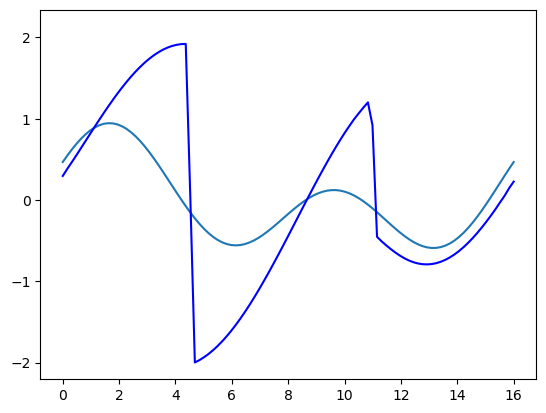

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm

u_n = u_base[0]
x_n = x[0]

fig, ax = plt.subplots()

# Store the plot handle at each time step in the 'ims' list
ims = []
for i in tqdm(range(tn)):
    im = ax.plot(x_n, u_n[i],'b-', animated=True)
    if i == 0:
        ax.plot(x_n, u_n[i].squeeze())  # show an initial one first
    ax.plot
    ims.append([im[0]])

# Animate the plot
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

writer = animation.PillowWriter(fps=15, bitrate=1800)
ani.save("assets/movie_E1_5_1.gif", writer=writer)

## GPT Setup

In [50]:
from common.utils import HDF5Dataset
from torch.utils.data import DataLoader
from experiments.models_gpt import GPT

pde = 'CE'
experiment = 'E1'
train_string = f'data/{pde}_train_{experiment}.h5'
dataset = HDF5Dataset(train_string, pde=pde, mode='train')
train_loader = DataLoader(dataset,
                        batch_size=2,
                        shuffle=True,
                        num_workers=4)

config = {"batch_size" : 2, # if gradient_accumulation_steps > 1, this is the micro-batch size
        "n_x": 100, 
        "block_size" : 250, # max sequence length for predicting next timestep. Sequence length can be shorter.
        "n_layer" : 3, 
        "n_head" : 8,
        "n_embd" : 256,
        "n_gnn": 100,
        "dropout" : 0.0, # for pretraining 0 is good, for finetuning try 0.1+
        "bias" : False # do we use bias inside LayerNorm and Linear layers?
}

model = GPT(config)
u_base, u_super, x, variables = next(iter(train_loader))
out = model(u_base[:, :250, :])

number of parameters: 2.48M


In [51]:
out2 = model(u_base[:, :100, :])

In [54]:
torch.allclose(out[:, :100, :], out2[:, :100, :])

True

## GNN Setup

In [27]:
from common.utils import HDF5Dataset
from torch.utils.data import DataLoader
from experiments.models_gpt import GPT
from common.utils import GraphCreator
from equations.PDEs import *
import random
from experiments.models_gnn import MP_PDE_Solver

pde = 'CE'
experiment = 'E1'
train_string = f'data/{pde}_train_{experiment}.h5'
dataset = HDF5Dataset(train_string, pde=pde, mode='train')
loader = DataLoader(dataset,
                        batch_size=2,
                        shuffle=True,
                        num_workers=4)

u_base, u_super, x, variables = next(iter(loader))

base_resolution = (250, 100)
pde = CE()
pde.tmin = dataset.tmin
pde.tmax = dataset.tmax
pde.grid_size = base_resolution
pde.dt = dataset.dt
graph_creator = GraphCreator(pde=pde,
                            neighbors=2,
                            time_window=20,
                            t_resolution=base_resolution[0],
                            x_resolution=base_resolution[1])

unrolling = [r for r in range(2 + 1)]
unrolled_graphs = 1
steps = [t for t in range(graph_creator.tw,
                            graph_creator.t_res - graph_creator.tw - (graph_creator.tw * unrolled_graphs) + 1)]
random_steps = random.choices(steps, k=2)
data, labels = graph_creator.create_data(u_super, random_steps)
data_gpt = u_super

config = {"batch_size" : 2, # if gradient_accumulation_steps > 1, this is the micro-batch size
        "n_x": 100, 
        "block_size" : 250, # max sequence length for predicting next timestep. Sequence length can be shorter.
        "n_layer" : 3, 
        "n_head" : 8,
        "n_embd" : 256,
        "n_gnn": 100,
        "dropout" : 0.0, # for pretraining 0 is good, for finetuning try 0.1+
        "bias" : False # do we use bias inside LayerNorm and Linear layers?
}

model_gpt = GPT(config)
embeddings = model_gpt(data_gpt)
graph = graph_creator.create_graph(data, embeddings, labels, x, variables, random_steps)

eq_variables = {}
model = MP_PDE_Solver(pde=pde,
                        time_window=graph_creator.tw,
                        eq_variables=eq_variables)

pred = model(graph)

number of GPT parameters: 2.48M


In [35]:
_, newlabels = graph_creator.create_data(u_super, newsteps)
olde = torch.clone(graph.e)
oldx = torch.clone(graph.x)
print(torch.allclose(labels, newlabels))
graph = graph_creator.create_next_graph(graph, pred, embeddings, newlabels, newsteps)

False


In [38]:
import torch
torch.cuda.is_available()

/home/cmu/anaconda3/envs/torch2/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /opt/conda/conda-bld/pytorch_1695392026823/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


False

In [32]:
labels.shape

torch.Size([2, 20, 100])

In [23]:
random_steps

[100, 219]

In [24]:
newsteps

[120, 239]

In [18]:
torch.allclose(oldx, pred)

True

In [7]:
torch.allclose(pred, graph.x)

True

In [16]:
test.shape

torch.Size([200, 20])

In [17]:
pred.shape

torch.Size([200, 20])

In [18]:
torch.allclose(pred, test)

True

In [3]:
random_steps = [rs + graph_creator.tw for rs in random_steps]
_, labels = graph_creator.create_data(u_super, random_steps)

In [4]:
random_steps

[183, 77]

In [5]:
next_graph = graph_creator.create_next_graph(graph, pred, labels, random_steps)

In [6]:
next_graph.e.shape

torch.Size([200, 20])

In [2]:
graph.x.shape

torch.Size([200, 20])

In [3]:
pred.shape

torch.Size([200, 20])

## Training Setup

In [1]:
from common.utils import HDF5Dataset
from torch.utils.data import DataLoader
from experiments.models_gpt import GPT
from common.utils import GraphCreator, CosineLearningRateScheduler
from equations.PDEs import *
import random
from experiments.models_gnn import MP_PDE_Solver
import wandb

In [1]:
from common.utils import HDF5Dataset
from torch.utils.data import DataLoader
from experiments.models_gpt import GPT
from common.utils import GraphCreator
from equations.PDEs import *
import random
from experiments.models_gnn import MP_PDE_Solver
import wandb
from experiments.train_helper import *
from datetime import datetime

def train(gnn_config: dict,
          pde: PDE,
          epoch: int,
          model_gnn: torch.nn.Module,
          optimizer_gnn: torch.optim,
          loader: DataLoader,
          graph_creator: GraphCreator,
          criterion: torch.nn.modules.loss,
          model_gpt: torch.nn.Module = None,
          optimizer_gpt: torch.optim = None,
          device: torch.cuda.device="cpu") -> None:
    """
    Training loop.
    Loop is over the mini-batches and for every batch we pick a random timestep.
    This is done for the number of timesteps in our training sample, which covers a whole episode.
    Args:
        args (argparse): command line inputs
        pde (PDE): PDE at hand [CE, WE, ...]
        model (torch.nn.Module): neural network PDE solver
        optimizer (torch.optim): optimizer used for training
        loader (DataLoader): training dataloader
        graph_creator (GraphCreator): helper object to handle graph data
        criterion (torch.nn.modules.loss): criterion for training
        device (torch.cuda.device): device (cpu/gpu)
    Returns:
        None
    """
    print(f'Starting epoch {epoch}...')
    print(f"Epoch {epoch}")
    if(use_gpt):
        model_gpt.train()
    model_gnn.train()

    max_unrolling = epoch if epoch <= gnn_config["unrolling"] else gnn_config["unrolling"]
    unrolling = [r for r in range(max_unrolling + 1)]

    # Loop over every epoch as often as the number of timesteps in one trajectory.
    # Since the starting point is randomly drawn, this in expectation has every possible starting point/sample combination of the training data.
    # Therefore in expectation the whole available training information is covered.
    for i in range(graph_creator.t_res):
        losses = training_loop(model_gnn, unrolling, gnn_config["batch_size"], optimizer_gnn, loader, graph_creator, criterion, model_gpt, optimizer_gpt, device)
        print(f'Training Loss (progress: {i / graph_creator.t_res:.2f}): {torch.mean(losses)}')

def test(gnn_config: dict,
         pde: PDE,
         model_gnn: torch.nn.Module,
         loader: DataLoader,
         graph_creator: GraphCreator,
         criterion: torch.nn.modules.loss,
         model_gpt: torch.nn.Module = None,
         device: torch.cuda.device="cpu") -> torch.Tensor:
    """
    Test routine
    Both step wise and unrolled forward losses are computed
    and compared against low resolution solvers
    step wise = loss for one neural network forward pass at certain timepoints
    unrolled forward loss = unrolling of the whole trajectory
    Args:
        args (argparse): command line inputs
        pde (PDE): PDE at hand [CE, WE, ...]
        model (torch.nn.Module): neural network PDE solver
        loader (DataLoader): dataloader [valid, test]
        graph_creator (GraphCreator): helper object to handle graph data
        criterion (torch.nn.modules.loss): criterion for training
        device (torch.cuda.device): device (cpu/gpu)
    Returns:
        torch.Tensor: unrolled forward loss
    """
    model_gnn.eval()
    if(use_gpt):
        model_gpt.eval()

   # first we check the losses for different timesteps (one forward prediction array!)
    steps = [t for t in range(graph_creator.tw, graph_creator.t_res-graph_creator.tw + 1)]
    losses = test_timestep_losses(model=model_gnn,
                                  steps=steps,
                                  batch_size=gnn_config["batch_size"],
                                  loader=loader,
                                  graph_creator=graph_creator,
                                  criterion=criterion,
                                  gpt=model_gpt,
                                  device=device)

    # next we test the unrolled losses
    losses = test_unrolled_losses(model=model_gnn,
                                  steps=steps,
                                  batch_size=gnn_config["batch_size"],
                                  nr_gt_steps=2,
                                  nx_base_resolution=gnn_config["base_resolution"][1],
                                  loader=loader,
                                  graph_creator=graph_creator,
                                  criterion=criterion,
                                  gpt= model_gpt,
                                  device=device)

    return torch.mean(losses)


gpt_config = {
        ## GPT Config 
        "use_gpt": True,
        "max_iters": 20,
        "batch_size" : 16, # if gradient_accumulation_steps > 1, this is the micro-batch size
        "n_x": 100, 
        "block_size" : 250, # max sequence length for predicting next timestep. Sequence length can be shorter.
        "n_layer" : 3, 
        "n_head" : 8,
        "n_embd" : 128,
        "n_gnn": 100,
        "dropout" : 0.0, # for pretraining 0 is good, for finetuning try 0.1+
        "bias" : False, # do we use bias inside LayerNorm and Linear layers?
        "learning_rate": 1e-3,
        "pct_start": 0.1,
        "min_lr": 1e-4, # should be lr/10 ish
        "beta1" : 0.9,
        "beta2" : 0.95,
        "grad_clip": 1.0,
        "device": "cuda",

}

gnn_config = {
        ## GNN Config 

        "epochs": gpt_config["max_iters"],
        "batch_size": gpt_config["batch_size"],
        "n_x": gpt_config["n_x"],
        "experiment": "E1",
        "base_resolution": (250, 100),
        "super_resolution": (250, 200),
        "neighbors": 3,
        "time_window": 25,
        "lr": 1e-4,
        "lr_decay": 0.4,
        "unrolling": 1,
        "device": gpt_config["device"],
}
device = gpt_config["device"]
use_gpt = gpt_config["use_gpt"]
## GNN Initialization
pde = CE(device=device)
train_string = f'data/{pde}_train_{gnn_config["experiment"]}.h5'
valid_string = f'data/{pde}_valid_{gnn_config["experiment"]}.h5'
test_string = f'data/{pde}_test_{gnn_config["experiment"]}.h5'

train_dataset = HDF5Dataset(train_string, pde=pde, mode='train', base_resolution=gnn_config["base_resolution"], super_resolution=gnn_config["super_resolution"])
train_loader = DataLoader(train_dataset,
                        batch_size=gnn_config["batch_size"],
                        shuffle=True,
                        num_workers=4)

valid_dataset = HDF5Dataset(valid_string, pde=pde, mode='valid', base_resolution=gnn_config["base_resolution"], super_resolution=gnn_config["super_resolution"])
valid_loader = DataLoader(valid_dataset,
                            batch_size=gnn_config["batch_size"],
                            shuffle=False,
                            num_workers=4)

test_dataset = HDF5Dataset(test_string, pde=pde, mode='test', base_resolution=gnn_config["base_resolution"], super_resolution=gnn_config["super_resolution"])
test_loader = DataLoader(test_dataset,
                            batch_size=gnn_config["batch_size"],
                            shuffle=False,
                            num_workers=4)

pde.tmin = train_dataset.tmin
pde.tmax = train_dataset.tmax
pde.grid_size = gnn_config["base_resolution"]
pde.dt = train_dataset.dt

eq_variables = {}
if gnn_config["experiment"] == 'E2':
        print('Beta parameter added to the GNN solver')
        eq_variables['beta'] = 0.2
elif gnn_config["experiment"]  == 'E3':
        print('Alpha, beta, and gamma parameter added to the GNN solver')
        eq_variables['alpha'] = 3.
        eq_variables['beta'] = 0.4
        eq_variables['gamma'] = 1.
elif (gnn_config["experiment"]  == 'WE3'):
        print('Boundary parameters added to the GNN solver')
        eq_variables['bc_left'] = 1
        eq_variables['bc_right'] = 1

graph_creator = GraphCreator(   pde=pde,
                                neighbors=gnn_config["neighbors"],
                                time_window=gnn_config["time_window"],
                                t_resolution=gnn_config["base_resolution"][0],
                                x_resolution=gnn_config["base_resolution"][1],
                                use_gpt=use_gpt).to(device)

model_gnn = MP_PDE_Solver(pde=pde,
                        time_window=graph_creator.tw,
                        eq_variables=eq_variables,
                        use_gpt=use_gpt).to(device)

model_parameters = filter(lambda p: p.requires_grad, model_gnn.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Number of GNN parameters: {params}')

optimizer_gnn = torch.optim.AdamW(model_gnn.parameters(), lr=gnn_config["lr"], fused=True)
scheduler_gnn = torch.optim.lr_scheduler.MultiStepLR(optimizer_gnn, milestones=[gnn_config["unrolling"], 5, 10, 15], gamma=gnn_config["lr_decay"])

## GPT Initialization

if(use_gpt):
    model_gpt = GPT(gpt_config)
    model_gpt.to(device)
    optimizer_gpt = torch.optim.AdamW(model_gpt.parameters(), lr=gpt_config["learning_rate"], betas=(gpt_config["beta1"], gpt_config["beta2"]), fused=True)
    scheduler_gpt = torch.optim.lr_scheduler.OneCycleLR(optimizer_gpt, max_lr=gpt_config["learning_rate"], steps_per_epoch=graph_creator.t_res * len(train_loader), epochs=gpt_config["max_iters"], pct_start=gpt_config["pct_start"], anneal_strategy='cos', final_div_factor=gpt_config["learning_rate"]/gpt_config["min_lr"])
else:
    model_gpt = None
    optimizer_gpt = None
    scheduler_gpt = None


## Training
min_val_loss = 10e10
criterion = torch.nn.MSELoss(reduction="sum")
max_iters = gpt_config["max_iters"]

dateTimeObj = datetime.now()
timestring = f'{dateTimeObj.date().month}{dateTimeObj.date().day}{dateTimeObj.time().hour}{dateTimeObj.time().minute}'

save_path_gpt = f'models/GPT_{pde}_{gnn_config["experiment"]}_xresolution{gnn_config["base_resolution"][1]}-{gnn_config["super_resolution"][1]}_n{gnn_config["neighbors"]}_tw{gnn_config["time_window"]}_time{timestring}.pt'
save_path_gnn = f'models/GNN_{pde}_{gnn_config["experiment"]}_xresolution{gnn_config["base_resolution"][1]}-{gnn_config["super_resolution"][1]}_n{gnn_config["neighbors"]}_tw{gnn_config["time_window"]}_time{timestring}.pt'

save_path_log = f'logs/log_{pde}_{gnn_config["experiment"]}_xresolution{gnn_config["base_resolution"][1]}-{gnn_config["super_resolution"][1]}_n{gnn_config["neighbors"]}_tw{gnn_config["time_window"]}_time{timestring}.txt'

Number of GNN parameters: 676345
number of GPT parameters: 648448


In [4]:
len(train_loader)

128

In [2]:
x = torch.arange(5000*128)
y = []
for i in range(5000*128):
    y.append(scheduler_gpt.get_last_lr())
    scheduler_gpt.step()

/home/cmu/anaconda3/envs/torch2/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


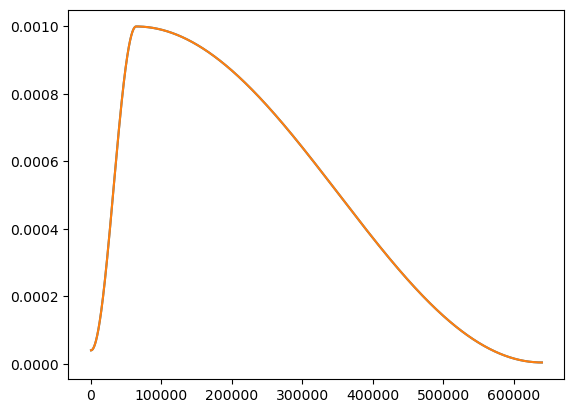

In [3]:
import matplotlib.pyplot as plt
plt.plot(x,y)

In [7]:
y[-1]

[4.000000000000001e-06, 4.000000000000001e-06]

In [5]:
for param_group in optimizer_gpt.param_groups:
    print(param_group['lr'])

4.000000007407193e-06
4.000000007407193e-06


In [2]:
epoch = 1
if(use_gpt):
    model_gpt.train()
model_gnn.train()

max_unrolling = epoch if epoch <= gnn_config["unrolling"] else gnn_config["unrolling"]
unrolling = [r for r in range(max_unrolling + 1)]
u_base, u_super, x, variables = next(iter(train_loader))

In [3]:

optimizer_gnn.zero_grad()
batch_size = gnn_config["batch_size"]
if model_gpt is not None:
    optimizer_gpt.zero_grad()
# Randomly choose number of unrollings
unrolled_graphs = 1
steps = [t for t in range(graph_creator.tw,
                            graph_creator.t_res - graph_creator.tw - (graph_creator.tw * unrolled_graphs) + 1)]
# Randomly choose starting (time) point at the PDE solution manifold
random_steps = random.choices(steps, k=batch_size)
data, labels = graph_creator.create_data(u_super, random_steps)

if model_gpt is not None:
    data_gpt = u_super.to(device)
    embeddings = model_gpt(data_gpt)
else:
    embeddings = None

if f'{model_gnn}' == 'GNN':
    graph = graph_creator.create_graph(data, labels, x, variables, random_steps, embeddings).to(device)
else:
    data, labels = data.to(device), labels.to(device)
# Unrolling of the equation which serves as input at the current step
# This is the pushforward trick!!!
with torch.no_grad():
    for _ in range(unrolled_graphs):
        random_steps = [rs + graph_creator.tw for rs in random_steps]
        _, labels = graph_creator.create_data(u_super, random_steps)
        if f'{model_gnn}' == 'GNN':
            pred = model_gnn(graph)
        else:
            data = model(data)
            labels = labels.to(device)

In [4]:
if f'{model_gnn}' == 'GNN':
    graph = graph_creator.create_next_graph(graph, pred, labels, random_steps, embeddings).to(device)
    pred = model_gnn(graph)
    loss = criterion(pred, graph.y)
else:
    pred = model(data)
    loss = criterion(pred, labels)

loss = torch.sqrt(loss)
loss.backward()

In [5]:
for param in model_gpt.parameters():
    print(param.grad)

tensor([[-0.0090, -0.0093, -0.0094,  ..., -0.0082, -0.0085, -0.0088],
        [ 0.0174,  0.0178,  0.0181,  ...,  0.0163,  0.0167,  0.0172],
        [ 0.0054,  0.0052,  0.0050,  ...,  0.0059,  0.0057,  0.0055],
        ...,
        [ 0.0007,  0.0016,  0.0024,  ..., -0.0015, -0.0007,  0.0001],
        [-0.0080, -0.0095, -0.0108,  ..., -0.0042, -0.0056, -0.0071],
        [ 0.0068,  0.0066,  0.0064,  ...,  0.0071,  0.0070,  0.0069]],
       device='cuda:0')
tensor([-0.0030,  0.0052, -0.0070, -0.0197, -0.0055, -0.0072, -0.0029,  0.0075,
        -0.0118,  0.0026, -0.0044,  0.0069,  0.0076, -0.0063, -0.0022, -0.0028,
        -0.0047, -0.0038,  0.0103, -0.0137, -0.0068, -0.0076,  0.0005,  0.0129,
         0.0141, -0.0052,  0.0024,  0.0085,  0.0111,  0.0084, -0.0139, -0.0010,
         0.0135, -0.0003,  0.0082,  0.0049,  0.0023, -0.0066, -0.0037, -0.0171,
        -0.0042,  0.0010,  0.0002, -0.0055,  0.0048, -0.0040, -0.0010, -0.0154,
        -0.0088,  0.0136, -0.0269,  0.0076, -0.0107,  0.0081, 

In [6]:
for param in model_gnn.parameters():
    print(param.grad)

tensor([[ 2.5561e-04, -5.5186e-05,  1.2829e-04,  ...,  9.1160e-04,
          9.1666e-04,  8.9178e-04],
        [ 3.1605e-04,  1.7700e-05,  6.2522e-05,  ...,  1.4610e-04,
          1.4119e-04,  1.2276e-04],
        [-7.1230e-04,  4.2990e-05, -2.5492e-04,  ...,  8.5922e-04,
          8.5840e-04,  8.6176e-04],
        ...,
        [ 5.6017e-04, -7.5279e-05,  2.8591e-04,  ...,  3.3151e-04,
          3.3894e-04,  3.1158e-04],
        [ 9.9086e-04,  2.9477e-05,  3.7164e-04,  ..., -1.0243e-03,
         -1.0335e-03, -1.0643e-03],
        [-2.9048e-04,  8.6005e-05, -2.1282e-04,  ..., -1.2454e-04,
         -1.3381e-04, -1.0166e-04]], device='cuda:0')
tensor([-3.0144e-04, -2.5398e-04, -2.9271e-04,  3.9656e-04,  3.3651e-04,
         1.0991e-04, -7.6409e-05, -2.4294e-04, -2.0292e-04,  3.4781e-04,
         3.8970e-04, -2.3587e-05, -4.6191e-05,  2.1332e-04,  6.7622e-04,
        -2.6939e-04,  3.1995e-04, -4.8030e-04, -4.9949e-05,  2.6803e-04,
         3.5171e-04, -1.6816e-04,  3.2808e-04,  3.6962e-04,

In [18]:
for param_group in optimizer_gpt.param_groups:
    print(param_group['lr'])

1.5e-06
1.5e-06


In [17]:
scheduler_gpt.step()

## Visualizations

In [13]:
## Load model
## Generate initial condition
## Propagate in time

from common.utils import HDF5Dataset
from torch.utils.data import DataLoader
from experiments.models_gpt import GPT
from common.utils import GraphCreator, CosineLearningRateScheduler
from equations.PDEs import *
import random
from experiments.models_gnn import MP_PDE_Solver
import wandb
from experiments.train_helper import *
from datetime import datetime

gpt_config = {
        ## GPT Config 
        "use_gpt": True,
        "max_iters": 20,
        "batch_size" : 1, # if gradient_accumulation_steps > 1, this is the micro-batch size
        "n_x": 100, 
        "block_size" : 250, # max sequence length for predicting next timestep. Sequence length can be shorter.
        "n_layer" : 3, 
        "n_head" : 8,
        "n_embd" : 128,
        "n_gnn": 100,
        "dropout" : 0.0, # for pretraining 0 is good, for finetuning try 0.1+
        "bias" : False, # do we use bias inside LayerNorm and Linear layers?
        "learning_rate": 1e-3,
        "warmup": 2000,
        "min_lr": 1e-4, # should be lr/10 ish
        "weight_decay": 1e-1,
        "beta1" : 0.9,
        "beta2" : 0.95,
        "grad_clip": 1.0,
        "decay_iters": 100,
        "device": "cuda",

}

gnn_config = {
        ## GNN Config 

        "epochs": gpt_config["max_iters"],
        "batch_size": gpt_config["batch_size"],
        "n_x": gpt_config["n_x"],
        "experiment": "E1",
        "base_resolution": (250, 100),
        "super_resolution": (250, 200),
        "neighbors": 3,
        "time_window": 25,
        "lr": 1e-4,
        "lr_decay": 0.4,
        "unrolling": 1,
        "device": gpt_config["device"],
}

config = gpt_config | gnn_config
use_gpt = gpt_config["use_gpt"]

## GPT Initialization
device = gpt_config["device"]

if(use_gpt):
    model_gpt = GPT(gpt_config)
    model_gpt.to(device)
    optimizer_gpt = model_gpt.configure_optimizers( gpt_config["weight_decay"], 
                                                    gpt_config["learning_rate"], 
                                                    (gpt_config["beta1"], gpt_config["beta2"]), 
                                                    gpt_config["device"]) # Makes AdamW optimizer based on model params

    scheduler_gpt = CosineLearningRateScheduler(    optimizer_gpt, 
                                                    gpt_config["warmup"], 
                                                    gpt_config["learning_rate"], 
                                                    gpt_config["min_lr"], 
                                                    gpt_config["decay_iters"])
else:
    model_gpt = None
    optimizer_gpt = None
    scheduler_gpt = None

## GNN Initialization
pde = CE(device=device)
train_string = f'data/{pde}_train_{gnn_config["experiment"]}.h5'
valid_string = f'data/{pde}_valid_{gnn_config["experiment"]}.h5'
test_string = f'data/{pde}_test_{gnn_config["experiment"]}.h5'

train_dataset = HDF5Dataset(train_string, pde=pde, mode='train', base_resolution=gnn_config["base_resolution"], super_resolution=gnn_config["super_resolution"])
train_loader = DataLoader(train_dataset,
                        batch_size=gnn_config["batch_size"],
                        shuffle=True,
                        num_workers=4)

valid_dataset = HDF5Dataset(valid_string, pde=pde, mode='valid', base_resolution=gnn_config["base_resolution"], super_resolution=gnn_config["super_resolution"])
valid_loader = DataLoader(valid_dataset,
                            batch_size=gnn_config["batch_size"],
                            shuffle=False,
                            num_workers=4)

test_dataset = HDF5Dataset(test_string, pde=pde, mode='test', base_resolution=gnn_config["base_resolution"], super_resolution=gnn_config["super_resolution"])
test_loader = DataLoader(test_dataset,
                            batch_size=gnn_config["batch_size"],
                            shuffle=False,
                            num_workers=4)

pde.tmin = train_dataset.tmin
pde.tmax = train_dataset.tmax
pde.grid_size = gnn_config["base_resolution"]
pde.dt = train_dataset.dt

eq_variables = {}
if gnn_config["experiment"] == 'E2':
        print('Beta parameter added to the GNN solver')
        eq_variables['beta'] = 0.2
elif gnn_config["experiment"]  == 'E3':
        print('Alpha, beta, and gamma parameter added to the GNN solver')
        eq_variables['alpha'] = 3.
        eq_variables['beta'] = 0.4
        eq_variables['gamma'] = 1.
elif (gnn_config["experiment"]  == 'WE3'):
        print('Boundary parameters added to the GNN solver')
        eq_variables['bc_left'] = 1
        eq_variables['bc_right'] = 1

graph_creator = GraphCreator(   pde=pde,
                                neighbors=gnn_config["neighbors"],
                                time_window=gnn_config["time_window"],
                                t_resolution=gnn_config["base_resolution"][0],
                                x_resolution=gnn_config["base_resolution"][1],
                                use_gpt=use_gpt).to(device)

model_gnn = MP_PDE_Solver(pde=pde,
                        time_window=graph_creator.tw,
                        eq_variables=eq_variables,
                        use_gpt=use_gpt).to(device)

model_parameters = filter(lambda p: p.requires_grad, model_gnn.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Number of GNN parameters: {params}')

optimizer_gnn = torch.optim.AdamW(model_gnn.parameters(), lr=gnn_config["lr"], fused=True)
scheduler_gnn = torch.optim.lr_scheduler.MultiStepLR(optimizer_gnn, milestones=[gnn_config["unrolling"], 5, 10, 15], gamma=gnn_config["lr_decay"])

number of GPT parameters: 0.65M
num decayed parameter tensors: 15, with 647,424 parameters
num non-decayed parameter tensors: 8, with 1,024 parameters
using fused AdamW: True
Number of GNN parameters: 637945


In [45]:
checkpoint_gnn = torch.load("/home/cmu/anthony/gpt-mp-solver/models/good/GNN_CE_E1_xresolution100-200_n3_tw25_time1131326.pt")
checkpoint_gpt = torch.load("/home/cmu/anthony/gpt-mp-solver/models/good/GPT_CE_E1_xresolution100-200_n3_tw25_time1131326.pt")

model_gnn.load_state_dict(checkpoint_gnn)
model_gnn.eval()

model_gpt.load_state_dict(checkpoint_gpt)
model_gpt.eval()
batch_size = 1
nr_gt_steps = 1

u_base, u_super, x, variables = next(iter(test_loader))
with torch.no_grad():
    same_steps = [graph_creator.tw*nr_gt_steps] * batch_size
    data, labels = graph_creator.create_data(u_super, same_steps)

    data_gpt = u_super.to(device)
    embeddings = model_gpt(data_gpt)

    graph = graph_creator.create_graph(data, labels, x, variables, same_steps, embeddings).to(device)
    traj = graph.x
    pred = model_gnn(graph)
    traj = torch.cat((traj, pred), dim=1)

    # Unroll trajectory and add losses which are obtained for each unrolling
    for step in range(graph_creator.tw * (nr_gt_steps + 1), graph_creator.t_res - graph_creator.tw + 1, graph_creator.tw):
        same_steps = [step] * batch_size
        _, labels = graph_creator.create_data(u_super, same_steps)
        graph = graph_creator.create_next_graph(graph, pred, labels, same_steps, embeddings).to(device)
        pred = model_gnn(graph)
        traj = torch.cat((traj, pred), dim=1)

traj = torch.transpose(traj, 0,1)
traj_true = u_super[0]



In [50]:
import matplotlib.pyplot as plt

def plot_traj(traj, title):
    N = traj.shape[0]
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,N)))

    fig, ax = plt.subplots()
    x = torch.linspace(0, 2, traj.shape[1])
    for i in range(N):
        ax.plot(x, traj[i])
    plt.title(title)
    plt.show()

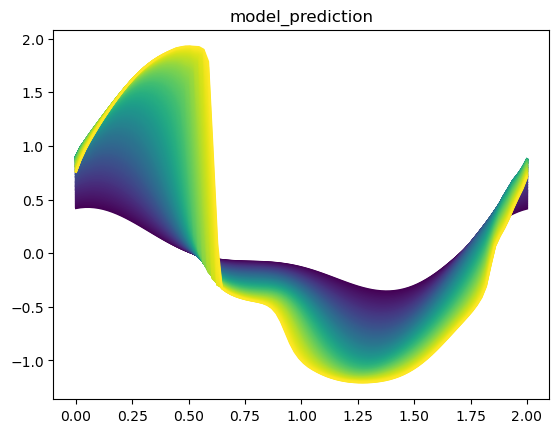

In [51]:
plot_traj(traj.detach().cpu(), "model_prediction")

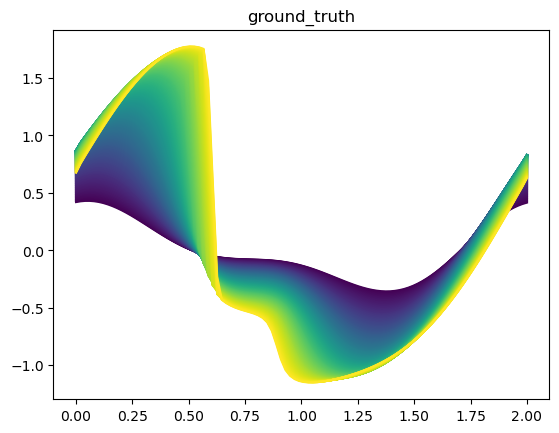

In [52]:
plot_traj(traj_true.detach().cpu(), "ground_truth")

In [24]:
idx = 0
u_base, u_super, x, variables = valid_dataset.__getitem__(idx)
gt = valid_dataset.data['pde_250-200'][idx]

tw = graph_creator.tw

with torch.no_grad():
    
    data, labels = graph_creator.create_data(u_super, same_steps)

    if gpt is not None:
        data_gpt = u_super.to(device)
        embeddings = gpt(data_gpt)
    else:
        embeddings = None

    if f'{model}' == 'GNN':
        graph = graph_creator.create_graph(data, labels, x, variables, same_steps, embeddings).to(device)
        pred = model(graph)
        loss = criterion(pred, graph.y) / nx_base_resolution
    else:
        data, labels = data.to(device), labels.to(device)
        pred = model(data)
        loss = criterion(pred, labels) / nx_base_resolution

    losses_tmp.append(loss / batch_size)

    # Unroll trajectory and add losses which are obtained for each unrolling
    for step in range(graph_creator.tw * (nr_gt_steps + 1), graph_creator.t_res - graph_creator.tw + 1, graph_creator.tw):
        same_steps = [step] * batch_size
        _, labels = graph_creator.create_data(u_super, same_steps)
        if f'{model}' == 'GNN':
            graph = graph_creator.create_next_graph(graph, pred, labels, same_steps, embeddings).to(device)
            pred = model(graph)
            loss = criterion(pred, graph.y) / nx_base_resolution
        else:
            labels = labels.to(device)
            pred = model(pred)
            loss = criterion(pred, labels) / nx_base_resolution
        losses_tmp.append(loss / batch_size)

In [25]:
u_super.shape

(250, 100)

In [11]:
gt = valid_dataset.data['pde_250-200'][0]

In [12]:
gt.shape

(250, 200)

In [17]:
x

array([ 0.        ,  0.16161616,  0.32323232,  0.48484848,  0.64646465,
        0.80808081,  0.96969697,  1.13131313,  1.29292929,  1.45454545,
        1.61616162,  1.77777778,  1.93939394,  2.1010101 ,  2.26262626,
        2.42424242,  2.58585859,  2.74747475,  2.90909091,  3.07070707,
        3.23232323,  3.39393939,  3.55555556,  3.71717172,  3.87878788,
        4.04040404,  4.2020202 ,  4.36363636,  4.52525253,  4.68686869,
        4.84848485,  5.01010101,  5.17171717,  5.33333333,  5.49494949,
        5.65656566,  5.81818182,  5.97979798,  6.14141414,  6.3030303 ,
        6.46464646,  6.62626263,  6.78787879,  6.94949495,  7.11111111,
        7.27272727,  7.43434343,  7.5959596 ,  7.75757576,  7.91919192,
        8.08080808,  8.24242424,  8.4040404 ,  8.56565657,  8.72727273,
        8.88888889,  9.05050505,  9.21212121,  9.37373737,  9.53535354,
        9.6969697 ,  9.85858586, 10.02020202, 10.18181818, 10.34343434,
       10.50505051, 10.66666667, 10.82828283, 10.98989899, 11.15

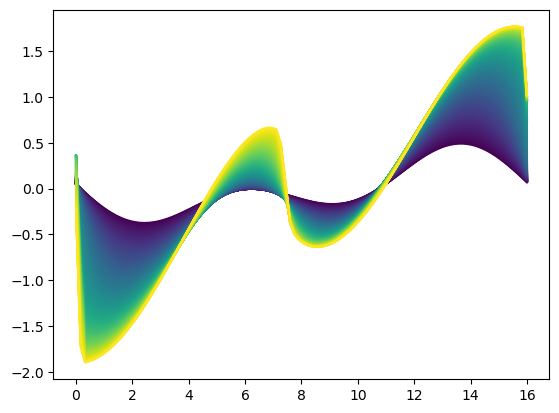

In [20]:
import matplotlib.pyplot as plt

N = 250
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,N)))

fig, ax = plt.subplots()
for i in range(N):
    ax.plot(x, u_super[i])

plt.show()

In [22]:
checkpoint_gnn = torch.load("/home/cmu/anthony/gpt-mp-solver/models/good/GNN_CE_E1_xresolution100-200_n3_tw25_time1131326.pt")
checkpoint_gpt = torch.load("/home/cmu/anthony/gpt-mp-solver/models/good/GPT_CE_E1_xresolution100-200_n3_tw25_time1131326.pt")

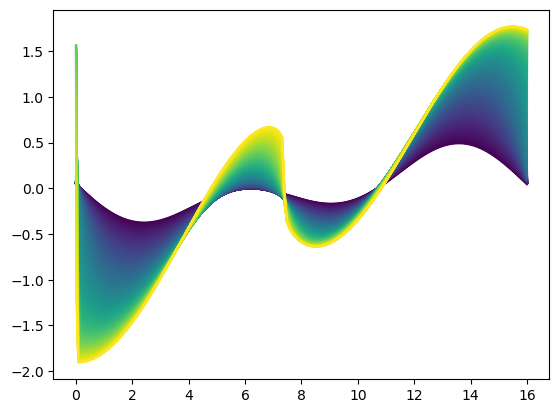

In [21]:
x_gt = torch.linspace(0, 16, 200)
N = 250
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,N)))

fig, ax = plt.subplots()
for i in range(N):
    ax.plot(x_gt, gt[i])

plt.show()